## Linear denoiser

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes
from yass.detect import nnet, nnet_experimental
from yass import preprocess

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


In [60]:
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [5]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

In [127]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

rec.shape

(6000000, 7)

In [128]:
path_to_detector = '/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/detect_nn2.ckpt'
detector = NeuralNetDetector.load(path_to_detector, 0.5, ch_idx)

(standarized_path,
 standarized_params,
 whiten_filter) = (preprocess
                   .run(if_file_exists='skip'))

(index_clean,
 index_all) = nnet_experimental.run(standarized_path, standarized_params, whiten_filter,
                                      'overwrite', False,
                                       path_to_detector,
                                       autoencoder='/home/Edu/data/cat/cat_0612_2.5ms_70um_aug20/ae_nn2.ckpt')

304it [00:05, 45.07it/s]                         


In [129]:
index_all.shape, index_clean.shape

((353263, 2), (79174, 2))

In [130]:
def kill_signal_from_index(recordings, spike_index, window_size):
    """
    """
    recordings = np.copy(recordings)

    T, C = recordings.shape
    R = int((window_size-1)/2)

    # this will hold a flag 1 (noise), 0 (signal) for every obseration in the
    # recordings
    is_noise_idx = np.zeros((T, C))

    # go through every neighboring channel
    for c in range(C):

        # get indexes whose main channel is c
        idx_temp = spike_index[spike_index[:, 1] == c]

        # shift every index found
        for j in range(-R, R+1):

            # shift
            idx_temp2 = idx_temp + j

            # remove indexes outside range [0, T]
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >= 0,
                                                 idx_temp2 < T)]

            # set surviving indexes to nan
            recordings[idx_temp2, c] = np.nan

        is_signal_idx_temp = np.isnan(recordings[:, c])

        # standarize data, ignoring nans
#         recordings[:, c] = recordings[:, c]/np.nanstd(recordings[:, c])

        # set non noise indexes to 0 in the recordings
        recordings[is_signal_idx_temp, c] = 0

        # save noise indexes
        is_noise_idx[~is_signal_idx_temp, c] = 1

    return recordings, is_noise_idx

In [126]:
rec, is_noise_idx = kill_signal_from_index(rec, index_all, 61)

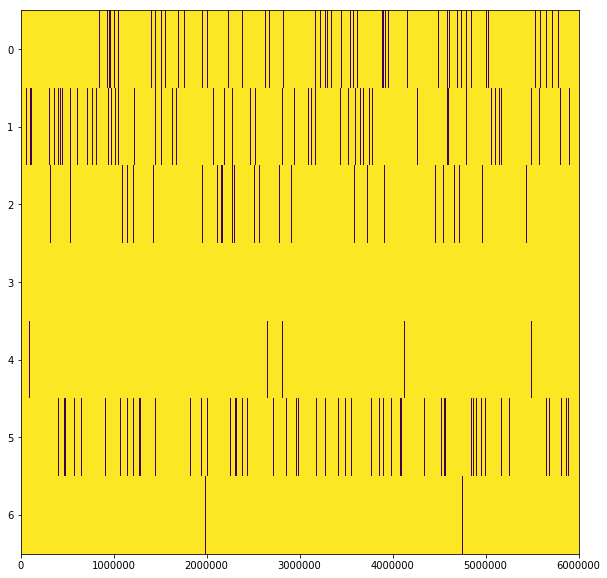

In [107]:
plt.imshow(is_noise_idx.T, aspect='auto')

In [108]:
noise_samples = noise_utils.search_noise_snippets(rec, is_noise_idx, sample_size=10000,
                                          temporal_size=51, channel_choices=CONFIG.channel_index[[0], :7],
                                          max_trials_per_sample=1000,
                                          allow_smaller_sample_size=False)
noise_samples.shape

(10000, 51, 7)

In [109]:
def sample(rec, waveform_length, n):
    min_idx = 0
    max_idx = rec.shape[0] - waveform_length

    idxs = np.random.randint(min_idx, max_idx, n)

    samples = np.empty((n, waveform_length, rec.shape[1]))

    for i, idx in enumerate(idxs):
        samples[i] = rec[i:i+waveform_length, :]
    
    return samples


def sample_noise(rec, waveform_length, n, detector, max_amplitude):
    
    noise = np.empty((n, waveform_length, rec.shape[1]))
    remaining = n
    
    while remaining > 0:
        wfs = sample(rec, waveform_length, n)

        noise_detector_idx = ~ detector.predict(wfs).astype(bool)
        noise_amplitude_idx = augment_util.amplitudes(wfs) <= max_amplitude
        noise_idx = noise_detector_idx & noise_amplitude_idx

        noise_found = noise_idx.sum()

        idx_start = n - remaining
        idx_end = idx_start + noise_found
                
        if idx_end > n:
            idx_end = n

        noise[idx_start:idx_end] = wfs[noise_idx][:idx_end-idx_start, :]
        
        remaining -= noise_found
    
    return noise

In [131]:
noise_samples = sample_noise(rec, 51, 10000, detector, 4)

In [132]:
noise_samples.shape

(10000, 51, 7)

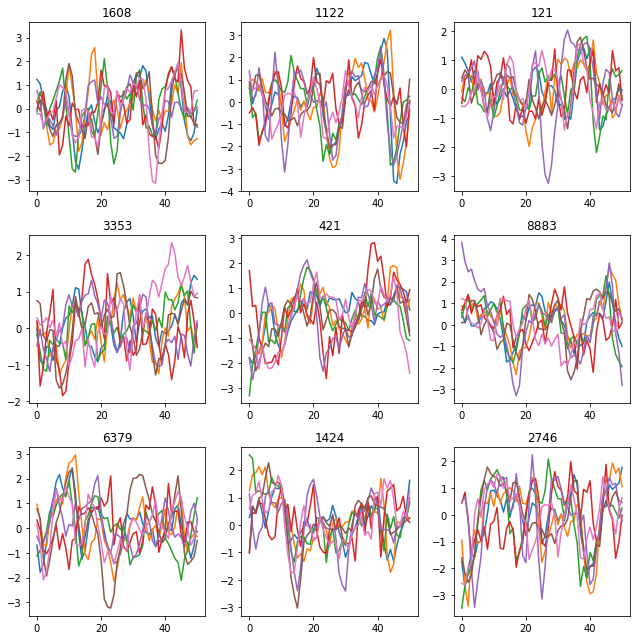

In [133]:
plot.grid_from_array(noise_samples, axis=0, elements=9, auto_figsize=3)

In [139]:
from sklearn.covariance import EmpiricalCovariance

In [140]:
noise_cov = (EmpiricalCovariance(store_precision=False, assume_centered=True)
             .fit(noise_samples.reshape(noise_samples.shape[0], -1))).covariance_

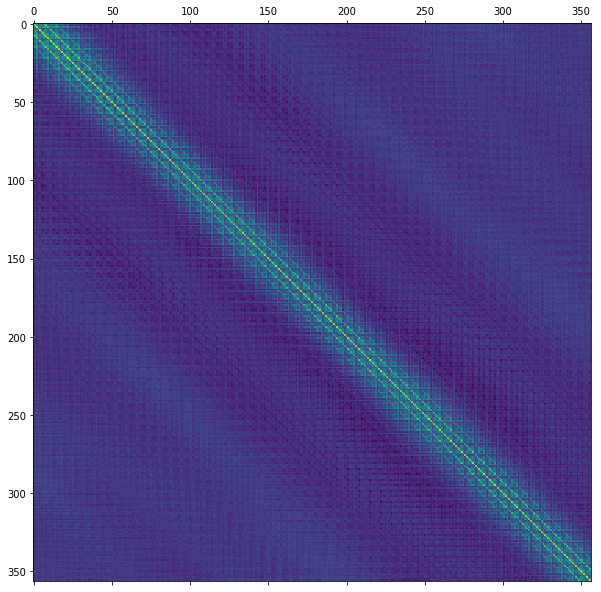

In [141]:
plt.matshow(noise_cov)

In [143]:
idxs = index_all[index_all[:, 1] == 0][:, 0]

In [148]:
def read_waveforms(rec, idxs, waveform_length):    
    out = np.empty((len(idxs), waveform_length, 7))
    half = int((waveform_length - 1)/2)
    
    for i, idx in enumerate(idxs):
        offset = -20 + np.random.randint(-20, 20)
        out[i] = rec[idx-half + offset:idx+half+1 + offset]
    
    return out

In [149]:
spikes = read_waveforms(rec, idxs, 51)
spikes.shape

(6909, 51, 7)

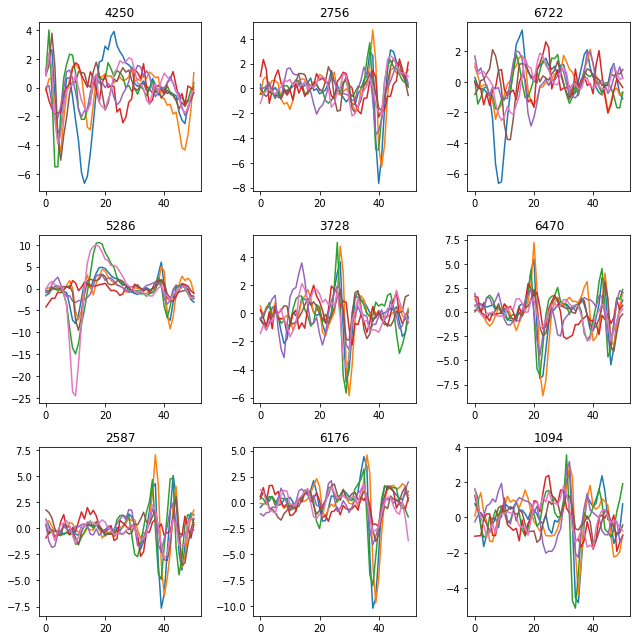

In [150]:
plot.grid_from_array(spikes, axis=0, elements=9, auto_figsize=3)

In [151]:
spikes_cov = (EmpiricalCovariance(store_precision=False, assume_centered=True)
                    .fit(spikes.reshape(spikes.shape[0], -1))).covariance_

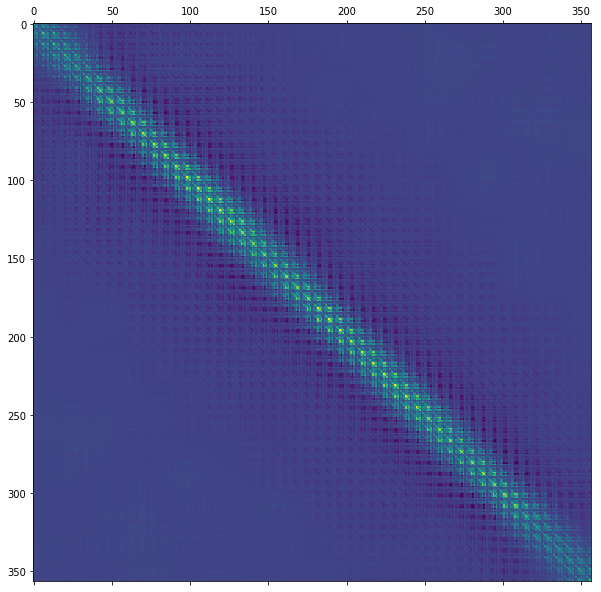

In [152]:
plt.matshow(spikes_cov)

In [153]:
cx = spikes_cov - noise_cov

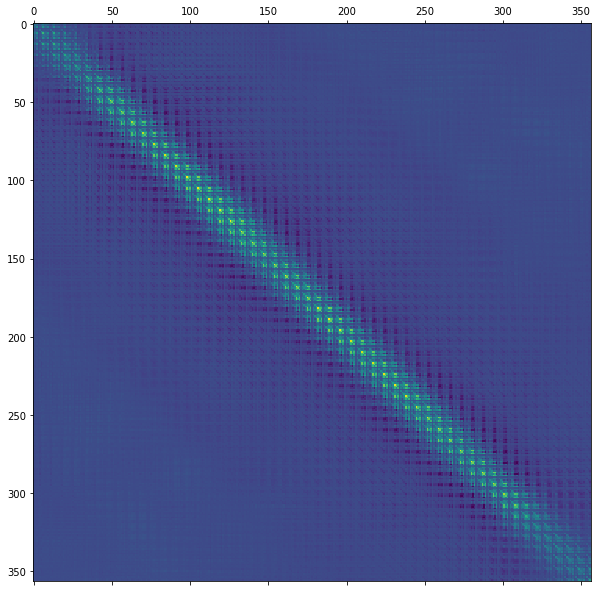

In [154]:
plt.matshow(cx)

In [155]:
mapping = np.matmul(np.linalg.inv(spikes_cov), cx)

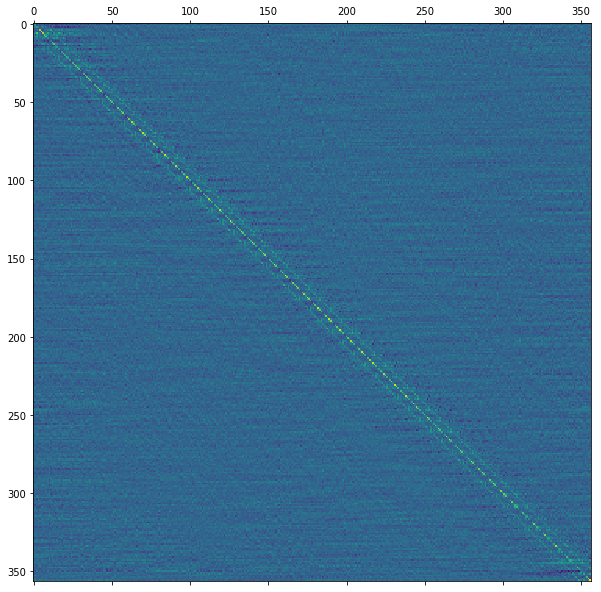

In [156]:
plt.matshow(mapping)

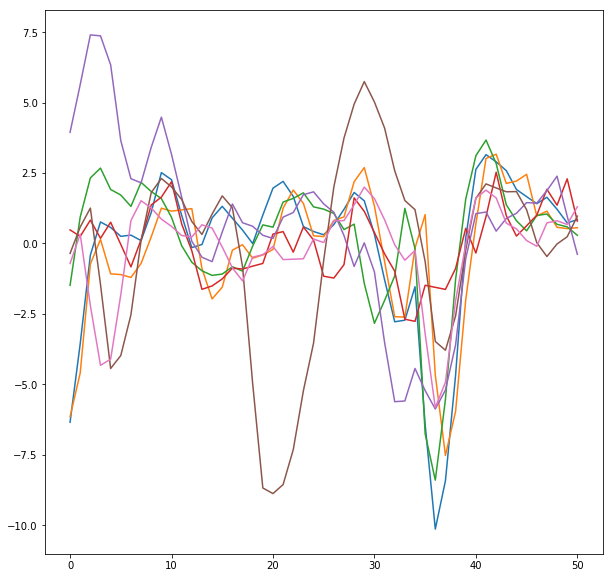

In [157]:
plt.plot(spikes[1])

In [158]:
denoised = np.matmul(spikes[1].flatten().T, mapping).reshape(51, 7)

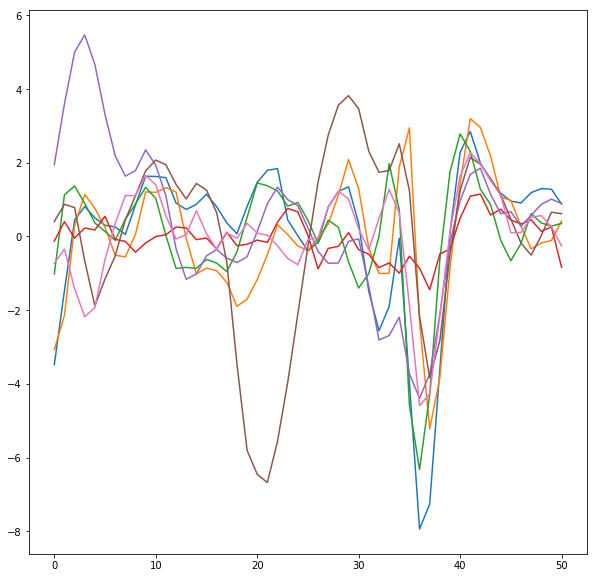

In [159]:
plt.plot(denoised)

In [160]:
denoised = np.matmul(spikes.reshape(spikes.shape[0], -1), mapping).reshape(-1, 51, 7)

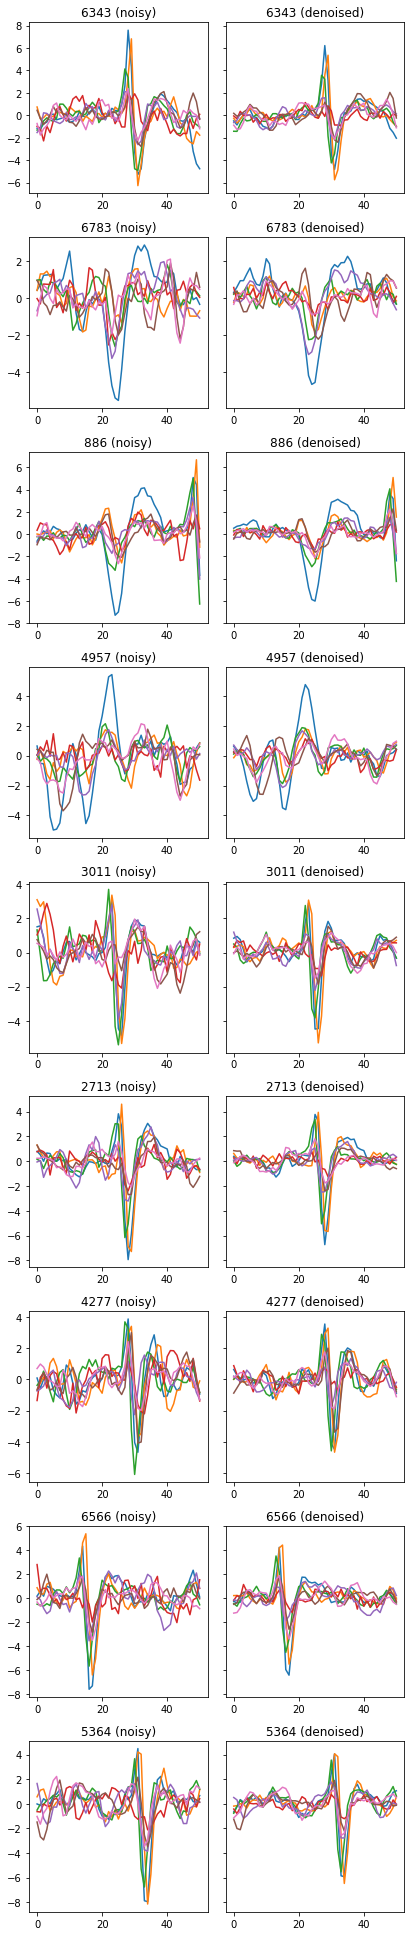

In [162]:
plot.grid_from_array([spikes, denoised], axis=0, elements=9, auto_figsize=3, sharey='row', group_names=['noisy', 'denoised'])

## Denoise recordings chunkwise

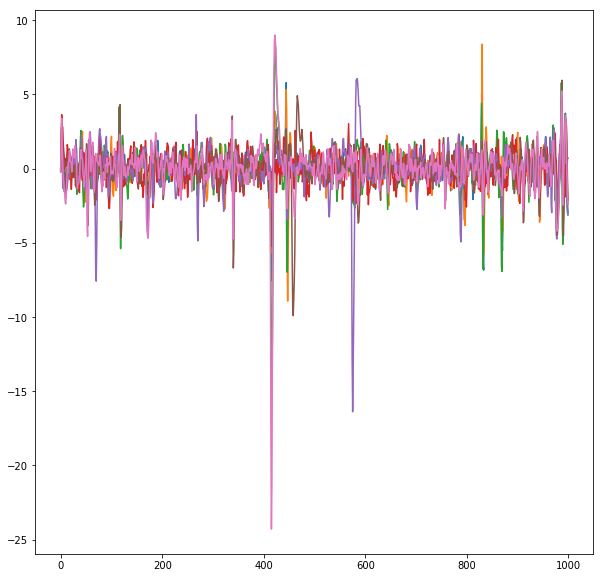

In [166]:
_ = plt.plot(rec[:1000, :])